Starting Point. Naive XGB with PCA and Fast ICA features. Store results for stacking also. Also, try to include the magic features and ID in the model.

In [156]:
%matplotlib inline
%run Functions.py

In [48]:
import warnings
warnings.filterwarnings('ignore')

In [223]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
train = pd.read_csv('data/train_c.csv')
test = pd.read_csv('data/test_c.csv')

**Prepare PCA/PCA Features**

In [224]:
from sklearn.decomposition import PCA, FastICA
n_comp = 20

# PCA
pca = PCA(n_components=n_comp, random_state=42)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=42)
ica2_results_train = ica.fit_transform(train.drop(["y"], axis=1))
ica2_results_test = ica.transform(test)

# Append decomposition components to datasets
for i in range(1, n_comp+1):
    train['pca_' + str(i)] = pca2_results_train[:,i-1]
    test['pca_' + str(i)] = pca2_results_test[:, i-1]
    
    train['ica_' + str(i)] = ica2_results_train[:,i-1]
    test['ica_' + str(i)] = ica2_results_test[:, i-1]
    
label = train["y"]
y_mean = np.mean(label)

## Original

In [51]:
# prepare dict of params for xgboost to run with
params = {
    'n_trees': 500, 
    'eta': 0.005,
    'max_depth': 4,
    'subsample': 0.95,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1
}

In [52]:
col = list(test.columns)[1:]

In [53]:
dtrain = xgb.DMatrix(train[col],label)
dtest = xgb.DMatrix(test[col])

[0]	train-rmse:12.6397+0.179397	test-rmse:12.6373+0.352742
[50]	train-rmse:11.0819+0.227932	test-rmse:11.1542+0.421412
[100]	train-rmse:9.99741+0.267214	test-rmse:10.1485+0.481267
[150]	train-rmse:9.25741+0.298283	test-rmse:9.49165+0.531394
[200]	train-rmse:8.75785+0.320606	test-rmse:9.07519+0.57259
[250]	train-rmse:8.42187+0.3356	test-rmse:8.81752+0.603745
[300]	train-rmse:8.19125+0.346645	test-rmse:8.66193+0.629895
[350]	train-rmse:8.00992+0.34462	test-rmse:8.57285+0.652287
[400]	train-rmse:7.86475+0.343391	test-rmse:8.52564+0.670495
[450]	train-rmse:7.74197+0.342036	test-rmse:8.50105+0.682156
[500]	train-rmse:7.61908+0.328162	test-rmse:8.48946+0.69033
[550]	train-rmse:7.50867+0.309231	test-rmse:8.48299+0.696632
Performance does not improve from 577 rounds


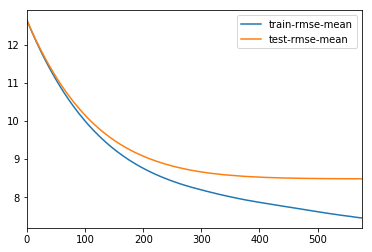

In [54]:
xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=True,seed=42)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

## Do Five Fold CV and Store Data

In [139]:
train = train.sample(frac=1,random_state=42)

In [61]:
stack_train,stack_pred,ID_list = get_xgb_stack_data(params,577,train,col,train['y'],test)

Training 1 Fold
R2 Scored of Fold 1 is 0.577925415464
Training 2 Fold
R2 Scored of Fold 2 is 0.437322236142
Training 3 Fold
R2 Scored of Fold 3 is 0.601450589252
Training 4 Fold
R2 Scored of Fold 4 is 0.604406875372
Training 5 Fold
R2 Scored of Fold 5 is 0.598623396209
Start Training
Calculating In-Bag R2 Score
0.629483013432
Calculating Out-Bag R2 Score
0.563945702488


In [78]:
save_results(stack_train,stack_pred,'xgb_depth2_557Rounds_0.5639_0.6295.csv')

Second Fold is quite bad. Have a look.

In [63]:
second_id = ID_list[1]

In [65]:
second_fold = train[train['ID'].isin(second_id)]

In [66]:
max(second_fold['y'])

265.31999999999999

## Try to Remove it?

In [72]:
train = train[train['y']<265.3]
label = train["y"]

In [73]:
col = list(test.columns)[1:]
dtrain = xgb.DMatrix(train[col],label)
dtest = xgb.DMatrix(test[col])

[0]	train-rmse:12.3844+0.160767	test-rmse:12.3832+0.319295
[50]	train-rmse:10.7817+0.146818	test-rmse:10.8693+0.347927
[100]	train-rmse:9.65925+0.139595	test-rmse:9.83401+0.361134
[150]	train-rmse:8.88753+0.13736	test-rmse:9.14894+0.361446
[200]	train-rmse:8.36373+0.137606	test-rmse:8.70916+0.352756
[250]	train-rmse:8.011+0.138069	test-rmse:8.43347+0.340435
[300]	train-rmse:7.76976+0.138537	test-rmse:8.2645+0.331106
[350]	train-rmse:7.59694+0.138666	test-rmse:8.16581+0.324116
[400]	train-rmse:7.46474+0.141517	test-rmse:8.1095+0.317391
[450]	train-rmse:7.35721+0.139842	test-rmse:8.08077+0.313071
[500]	train-rmse:7.26516+0.136449	test-rmse:8.06493+0.30837
[550]	train-rmse:7.18733+0.133317	test-rmse:8.0583+0.305311
[600]	train-rmse:7.11799+0.130786	test-rmse:8.05417+0.302325
Performance does not improve from 630 rounds


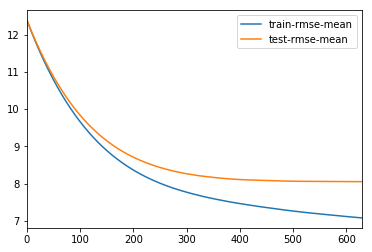

In [74]:
xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=True,seed=42,feval=xgb_r2_score)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

In [75]:
stack_train2,stack_pred2,ID_list2 = get_xgb_stack_data(params,630,train,col,train['y'],test)

Training 1 Fold
R2 Scored of Fold 1 is 0.579560135979
Training 2 Fold
R2 Scored of Fold 2 is 0.549713687361
Training 3 Fold
R2 Scored of Fold 3 is 0.602171744755
Training 4 Fold
R2 Scored of Fold 4 is 0.607908210172
Training 5 Fold
R2 Scored of Fold 5 is 0.602018538657
Start Training
Calculating In-Bag R2 Score
0.650764531228
Calculating Out-Bag R2 Score
0.588274463385


In [79]:
save_results(stack_train2,stack_pred2,'xgb_depth2_Rounds630_0.5882_0.6507.csv')

## Add Magic Features and ID

In [140]:
magic_mat = train[['ID','X0','y']]

In [141]:
magic_mat = magic_mat.groupby(['X0'])['y'].mean()

In [142]:
magic_mat = pd.DataFrame({'X0':magic_mat.index,'magic':list(magic_mat)})
mean_magic = magic_mat['magic'].mean()

In [143]:
mean_magic

102.52746181380456

In [144]:
train = train.merge(magic_mat,on='X0',how='left')

**Do a simple testing**

In [145]:
r2_score(train['magic'],train['y'])

0.26027924104822997

In [146]:
test = test.merge(magic_mat,on='X0',how = 'left')

In [147]:
test['magic'] = test['magic'].fillna(mean_magic)

**Do a CV for both xgb and KFold**

In [150]:
train = train.sample(frac = 1 ,random_state=42)
label = train['y']
col = list(test.columns)[1:]
dtrain = xgb.DMatrix(train[col],label)
dtest = xgb.DMatrix(test[col])

[0]	train-rmse:12.6376+0.276734	test-rmse:12.63+0.546938
[50]	train-rmse:11.0716+0.316007	test-rmse:11.1356+0.619953
[100]	train-rmse:9.9795+0.346766	test-rmse:10.1235+0.684702
[150]	train-rmse:9.22247+0.366708	test-rmse:9.45997+0.735861
[200]	train-rmse:8.69852+0.373979	test-rmse:9.03786+0.774386
[250]	train-rmse:8.32934+0.370375	test-rmse:8.77417+0.801049
[300]	train-rmse:8.06847+0.365836	test-rmse:8.61424+0.817613
[350]	train-rmse:7.86844+0.345875	test-rmse:8.52151+0.825393
[400]	train-rmse:7.7017+0.318021	test-rmse:8.46591+0.827506
[450]	train-rmse:7.56445+0.295545	test-rmse:8.43749+0.82727
[500]	train-rmse:7.45609+0.279292	test-rmse:8.42381+0.82577
[550]	train-rmse:7.35796+0.262182	test-rmse:8.41653+0.823521
[600]	train-rmse:7.2704+0.250445	test-rmse:8.4153+0.822144
Performance does not improve from 590 rounds


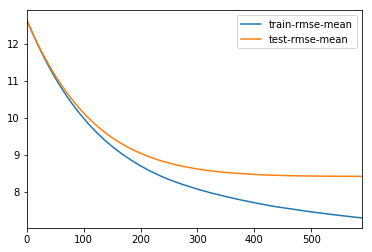

In [160]:
xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=True,seed=42)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

In [152]:
stack_train3,stack_pred3,ID_list3 = get_xgb_stack_data(params,590,train,col,train['y'],test)

Training 1 Fold
R2 Scored of Fold 1 is 0.559502430888
Training 2 Fold
R2 Scored of Fold 2 is 0.471694948838
Training 3 Fold
R2 Scored of Fold 3 is 0.576965272066
Training 4 Fold
R2 Scored of Fold 4 is 0.604297365045
Training 5 Fold
R2 Scored of Fold 5 is 0.548207173926
Start Training
Calculating In-Bag R2 Score
0.634822959798
Calculating Out-Bag R2 Score
0.552133438153


In [155]:
save_results(stack_train3,stack_pred3,'xgb_depth2_Rounds590_0.5639_0.6294.csv')

In [161]:
model = xgb.train(params,dtrain,num_boost_round=590)

## Do same procedure to all categorical data?

In [225]:
cat = ['X0','X1','X2','X3','X4','X5','X6','X8']

In [226]:
#train = pd.read_csv('data/train_c.csv')
#test = pd.read_csv('data/test_c.csv')

In [227]:
for i in range(len(cat)):
    var = cat[i]
    magic_mat = train[['ID',var,'y']]
    magic_mat = magic_mat.groupby([var])['y'].mean()
    magic_mat = pd.DataFrame({var:magic_mat.index,var+'_magic':list(magic_mat)})
    mean_magic = magic_mat[var+'_magic'].mean()
    train = train.merge(magic_mat,on=var,how='left')
    test = test.merge(magic_mat,on=var,how = 'left')
    test[var+'_magic'] = test[var+'_magic'].fillna(mean_magic)

[0]	train-rmse:12.6367+0.305796	test-rmse:12.6282+0.598816
[50]	train-rmse:11.0574+0.326955	test-rmse:11.14+0.680596
[100]	train-rmse:9.95092+0.341542	test-rmse:10.1292+0.738444
[150]	train-rmse:9.1835+0.346575	test-rmse:9.46313+0.777841
[200]	train-rmse:8.65219+0.342687	test-rmse:9.03587+0.799987
[250]	train-rmse:8.27784+0.331352	test-rmse:8.769+0.807766
[300]	train-rmse:8.01466+0.318846	test-rmse:8.60352+0.812606
[350]	train-rmse:7.8153+0.301921	test-rmse:8.50175+0.811864
[400]	train-rmse:7.65448+0.288744	test-rmse:8.44105+0.809086
[450]	train-rmse:7.52443+0.277672	test-rmse:8.40699+0.807124
[500]	train-rmse:7.4164+0.269206	test-rmse:8.387+0.803834
[550]	train-rmse:7.32405+0.262921	test-rmse:8.37695+0.799687
[600]	train-rmse:7.23541+0.251992	test-rmse:8.37223+0.798655
[650]	train-rmse:7.15721+0.243543	test-rmse:8.36853+0.79756
[700]	train-rmse:7.08389+0.235737	test-rmse:8.36701+0.794828
Performance does not improve from 701 rounds


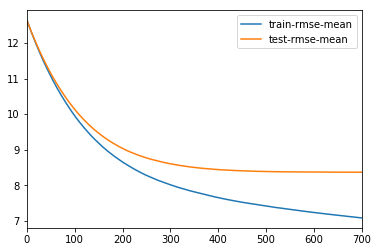

In [219]:
train = train.sample(frac = 1 ,random_state=42)
label = train['y']
col = list(test.columns)[1:]
dtrain = xgb.DMatrix(train[col],label)
dtest = xgb.DMatrix(test[col])
xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=True,seed=42)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

In [181]:
model = xgb.train(params,dtrain,num_boost_round=701)
get_feature_importance(model)

,Feature,Score
99,X0_magic,1326
13,X5_magic,570
4,X47,367
90,pca_1,362
55,ica_18,354
93,pca_13,318
87,ica_7,302
45,pca_9,300
57,pca_2,298
105,pca_8,280


In [182]:
stack_train4,stack_pred4,ID_list4 = get_xgb_stack_data(params,701,train,col,train['y'],test)

Training 1 Fold
R2 Scored of Fold 1 is 0.574771664384
Training 2 Fold
R2 Scored of Fold 2 is 0.443657934686
Training 3 Fold
R2 Scored of Fold 3 is 0.605522245802
Training 4 Fold
R2 Scored of Fold 4 is 0.594195112219
Training 5 Fold
R2 Scored of Fold 5 is 0.59866661899
Start Training
Calculating In-Bag R2 Score
0.663991359202
Calculating Out-Bag R2 Score
0.563362715216


In [183]:
save_results(stack_train4,stack_pred4,'xbg_depth2_701Rounds_0.5634_0.6640_All_Magics.csv')

## With Std

In [220]:
magic_var = []
for i in range(len(cat)):
    var = cat[i]
    magic_var.append(var+'_magic')
magic_var.remove('X0_magic')
magic_var.remove('X5_magic')

In [228]:
IDs = ['X0','X5']
for i in range(len(cat)):
    var = cat[i]
    magic_mat = train[['ID',var,'y']]
    magic_mat = magic_mat.groupby([var])['y'].std()
    magic_mat = pd.DataFrame({var:magic_mat.index,var+'_magic_std':list(magic_mat)})
    mean_magic = magic_mat[var+'_magic_std'].std()
    train = train.merge(magic_mat,on=var,how='left')
    test = test.merge(magic_mat,on=var,how = 'left')
    test[var+'_magic_std'] = test[var+'_magic_std'].fillna(mean_magic)

In [230]:
train = train.sample(frac = 1 ,random_state=42)
label = train['y']
col = list(test.columns)[1:]
#col = [each for each in col if each not in magic_var]
dtrain = xgb.DMatrix(train[col],label)
dtest = xgb.DMatrix(test[col])

[0]	train-rmse:12.6366+0.305737	test-rmse:12.6283+0.598697
[50]	train-rmse:11.05+0.321149	test-rmse:11.1448+0.675935
[100]	train-rmse:9.94256+0.335583	test-rmse:10.1365+0.731649
[150]	train-rmse:9.1735+0.341201	test-rmse:9.47125+0.768847
[200]	train-rmse:8.63806+0.335538	test-rmse:9.04443+0.789527
[250]	train-rmse:8.25627+0.319007	test-rmse:8.77748+0.798726
[300]	train-rmse:7.99268+0.307433	test-rmse:8.61127+0.802166
[350]	train-rmse:7.78706+0.288416	test-rmse:8.51131+0.799708
[400]	train-rmse:7.62626+0.276143	test-rmse:8.45039+0.797099
[450]	train-rmse:7.49387+0.265401	test-rmse:8.41558+0.793303
[500]	train-rmse:7.38047+0.255261	test-rmse:8.39528+0.786923
[550]	train-rmse:7.28525+0.248753	test-rmse:8.38744+0.780394
Performance does not improve from 572 rounds


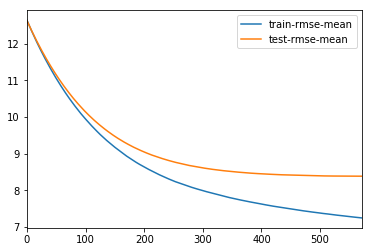

In [231]:
xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=True,seed=42)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

In [232]:
model = xgb.train(params,dtrain,num_boost_round=572)

In [234]:
stack_train5,stack_pred5,ID_list4 = get_xgb_stack_data(params,572,train,col,train['y'],test)

Training 1 Fold
R2 Scored of Fold 1 is 0.577246995475
Training 2 Fold
R2 Scored of Fold 2 is 0.44495116449
Training 3 Fold
R2 Scored of Fold 3 is 0.604559779649
Training 4 Fold
R2 Scored of Fold 4 is 0.595121202684
Training 5 Fold
R2 Scored of Fold 5 is 0.598039707951
Start Training
Calculating In-Bag R2 Score
0.650253283828
Calculating Out-Bag R2 Score
0.56398377005


In [235]:
save_results(stack_train5,stack_pred5,'xgb_depth2_rounds572_0.563984_0.65025_All_Magic_std.csv')